In [218]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [219]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, make_scorer, roc_auc_score, precision_recall_curve,f1_score, accuracy_score

In [220]:
filename = 'conversion_data.csv'
df = pd.read_csv(filename)
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [221]:
df.describe(exclude = None)

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Here we can see, that the max age is 123, which seems a little improbable; lets see how many entries we have above the age of 100

In [222]:
df.loc[df.age >= 100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


Only 2! Thats great, since we have 316200 entries, deleting 2 wont modify the data significantly

In [223]:
df = df.loc[df.age<100]

In [224]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316198.000000,316198.000000,316198.000000,316198.000000
mean,30.569311,0.685469,4.872918,0.032252
std,8.268958,0.464329,3.341053,0.176669
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,79.000000,1.000000,29.000000,1.000000


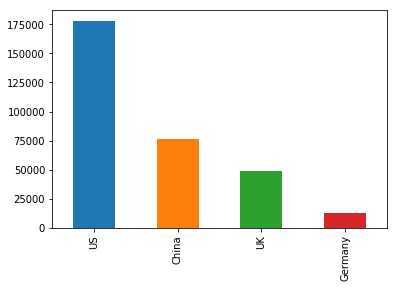

In [225]:
country_dist = df.country.value_counts()
country_dist.plot(kind='bar')

In [226]:
conv_country_dist = df[['country','converted']].groupby('country').agg(['mean','count'])
conv_country_dist

converted        
             mean   count
country                  
China    0.001332   76602
Germany  0.062428   13055
UK       0.052612   48449
US       0.037801  178092

From this table, we can see that there are a lot of users from China, but a poor conversion rate; little users from Germany, but good conversion rate (relatively)

From this we can make the conclusion that there is a problem with Chinese users on the site.

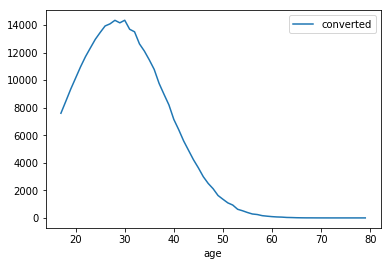

In [227]:
df[['age','converted']].groupby('age').agg('count').plot()

From this plot we can see that the conversion rate is high, and peaks, for our younger users, and decreases drastically as age increases after our 30 year old peak

Last, we want to see how the total pages visited affects the conversion rate

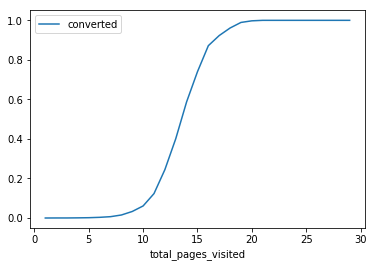

In [228]:
df[['total_pages_visited','converted']].groupby('total_pages_visited').agg('mean').plot()

From this plot we can see that typically, the more pages a user views, the more likely they are to convert(buy something).

In [229]:
df = pd.get_dummies(df)
df.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


In [230]:
X = df.drop('converted',axis = 1)
y = df.converted

In [231]:
y.mean()

0.03225194340255157

This could have also been observed before when we used describe() on our dataframe, however I wanted to explicitly point this out. The mean of our converted columns (our conversion rate) lies around 3.2%. Our goal is to report some ways to increase this rate.  This also tells us that our dependent variable is imblanced - and this is important to keep in mind.

Now it is time to split our data into a training set and a test set.

In [232]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size = .2)

In [233]:
ytrain.mean(), ytest.mean()

(0.03216344215245218, 0.03260594560404807)

Since the means of both the training set and test set are similar, we know that the data was split in a way that didnt import any bias.

# Classify via Logistic Regression

Our goal here is to find the importance of each feature; we want to find the magnitude of effect that each feature has on the outcome, to better understand which features should be focused on.

In [234]:
roc_auc_weighted = make_scorer(roc_auc_score, average='weighted')

In [235]:
#roc_auc scoring is used to take care of the class imbalance
#we also stick with the default L2 (Ridge) regularization - L1(LASSO) would normally be used when we
#are trying to perform feature selection, but since there arent that many features, and L2 typically
#performs better, we will stick with L2
classifier = LogisticRegressionCV(Cs = np.logspace(-3,3,7),scoring = 'roc_auc', max_iter =1000, n_jobs = -1, random_state = 1)
classifier.fit(Xtrain,ytrain)

LogisticRegressionCV(Cs=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=1000, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=1, refit=True,
           scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=0)

In [236]:
ypred = classifier.predict(Xtest)

In [249]:
yprob = classifier.predict_proba(Xtest)
roc_auc = roc_auc_score(ytest, yprob[:,1])
roc_auc

0.9870044706485113

In [245]:
classifier.score(Xtest,ytest)

0.9864010120177104

In [246]:
accuracy_score(ytest, ypred)

0.9864010120177104

In [239]:
cm = confusion_matrix(ytest,ypred)
print(cm)

[[60950   228]
 [  632  1430]]


In [240]:
accuracy_score(ytest,ypred)

0.9864010120177104

In [241]:
print(classification_report(y_true = ytest, y_pred = ypred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     61178
          1       0.86      0.69      0.77      2062

avg / total       0.99      0.99      0.99     63240



In [242]:
feat_importances = pd.DataFrame({"name":Xtrain.columns,"coef":classifier.coef_[0]})
feat_importances = feat_importances[['name','coef']]# reorder the columns
feat_importances['importances'] = np.abs( feat_importances['coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances

,name,coef,importances
3,country_China,-2.650323,2.650323
1,new_user,-1.729373,1.729373
4,country_Germany,1.074489,1.074489
5,country_UK,0.882767,0.882767
2,total_pages_visited,0.752132,0.752132
6,country_US,0.533004,0.533004
8,source_Direct,-0.175154,0.175154
0,age,-0.076678,0.076678
7,source_Ads,0.011959,0.011959
9,source_Seo,0.003133,0.003133


In [243]:
conv_country_dist

converted        
             mean   count
country                  
China    0.001332   76602
Germany  0.062428   13055
UK       0.052612   48449
US       0.037801  178092

From the two tables above, we can conclude the following:
    1. There is a poor conversion rate from our Chinese users, however, the same users impact our overall rate fairly significantly. China has a huge population, as well as a significant economy. It would benefit us as a company to make our site more "friendly" for our Chinese users. Perhaps we do not have our site in a Chinese translation, or our products are not attractive to our Chinese users. We should look into these points, and make necessary changes.
    2. There is a good conversion rate with our German users, however not many users. We can also see that our German users have a significant impact on our overall conversion. Perhps we need to advertise more in Germany, or find a way to get our name out to more people in that region (partnerships, etc.).

In [244]:
conv_user_dist = df[['new_user','converted']].groupby('new_user').agg(['mean','count'])
conv_user_dist

converted        
              mean   count
new_user                  
0         0.071983   99454
1         0.014021  216744

Our new user category seems to have a significant impact on our overall conversion, and from this table right above, we can see that we have a better conversion rate with our "older" users. 
With this information we can do two things:
    1. Create a loyalty program that benefits our users in order to keep them loyal to our company, and perhaps convince our newer users to be long-time users.
    2. Find a way to attract new users to buy things off of our site. Perhaps this will come in the form of a certain discount one can acquire when applying to become a member of our site.

We can see that total pages visited plays a role in whether or not our users will purchase something. The more pages one visits the more likely a user is to buy something. Perhaps we can include certain advertisements on our website that will persuade our users click them and therefore visit more pages; the logic behind this is that our users will become more familiar and comfortable with our products and our company, hopefully incentivizing them to make a purchase.